In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
from gensim.models import Word2Vec
import itertools
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,load_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from keras.utils.vis_utils import plot_model

df = pd.read_csv('cleaned_IMDB.csv')
df.head()

,review,cleaned_bert_review,cleaned_review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,bromwell high is a cartoon comedy it ran at th...,bromwell high cartoon comedy run time program ...,1
1,Homelessness (or Houselessness as George Carli...,homelessness or houselessness as george carlin...,homelessness houselessness george carlin state...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,brilliant overacting by lesley ann warren best...,brilliant overact lesley ann warren well drama...,1
3,This is easily the most underrated film inn th...,this is easily the most underrated film inn th...,easily underrated film inn brooks cannon sure ...,1
4,This is not the typical Mel Brooks film. It wa...,this is not the typical mel brooks film it was...,not typical mel brooks film much less slapstic...,1


In [36]:
df["sentiment"] = df["sentiment"].replace("pos",1)
df["sentiment"] = df["sentiment"].replace("neg",0)
df.head()

,review,cleaned_bert_review,cleaned_review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,bromwell high is a cartoon comedy it ran at th...,bromwell high cartoon comedy run time program ...,1
1,Homelessness (or Houselessness as George Carli...,homelessness or houselessness as george carlin...,homelessness houselessness george carlin state...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,brilliant overacting by lesley ann warren best...,brilliant overact lesley ann warren well drama...,1
3,This is easily the most underrated film inn th...,this is easily the most underrated film inn th...,easily underrated film inn brooks cannon sure ...,1
4,This is not the typical Mel Brooks film. It wa...,this is not the typical mel brooks film it was...,not typical mel brooks film much less slapstic...,1


In [37]:
df.shape

(50000, 4)

In [38]:
# Check the dataset is balanced or not
df.groupby('sentiment')["sentiment"].count()

sentiment
0    25000
1    25000
Name: sentiment, dtype: int64

In [39]:
# View the top 25000 data
df.head(25000)

,review,cleaned_bert_review,cleaned_review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,bromwell high is a cartoon comedy it ran at th...,bromwell high cartoon comedy run time program ...,1
1,Homelessness (or Houselessness as George Carli...,homelessness or houselessness as george carlin...,homelessness houselessness george carlin state...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,brilliant overacting by lesley ann warren best...,brilliant overact lesley ann warren well drama...,1
3,This is easily the most underrated film inn th...,this is easily the most underrated film inn th...,easily underrated film inn brooks cannon sure ...,1
4,This is not the typical Mel Brooks film. It wa...,this is not the typical mel brooks film it was...,not typical mel brooks film much less slapstic...,1
...,...,...,...,...
24995,"Towards the end of the movie, I felt it was to...",towards the end of the movie i felt it was too...,towards end movie feel technical feel like cla...,0
24996,This is the kind of movie that my enemies cont...,this is the kind of movie that my enemies cont...,kind movie enemy content watch time not bloody...,0
24997,I saw 'Descent' last night at the Stockholm Fi...,i saw descent last night at the stockholm film...,see descent last night stockholm film festival...,0
24998,Some films that you pick up for a pound turn o...,some films that you pick up for a pound turn o...,film pick pound turn rather good 23rd century ...,0


In [40]:
df_train = df.head(25000)
df_test = df.tail(25000)

In [41]:
df_train.groupby('sentiment')["sentiment"].count()

sentiment
0    12500
1    12500
Name: sentiment, dtype: int64

In [42]:
df_test.groupby('sentiment')["sentiment"].count()

sentiment
0    12500
1    12500
Name: sentiment, dtype: int64

In [43]:
tokenizer = Tokenizer()

imdb = df['cleaned_review'].values.tolist()
tokenizer.fit_on_texts(imdb)

In [44]:
sequences = []
max_sequence_len = 0

for text in imdb:
    # Convert texts to sequence
    txt_to_seq = tokenizer.texts_to_sequences([text])[0]
    sequences.append(txt_to_seq)
    # Find max_sequence_len for padding
    length = len(txt_to_seq)
    if length > max_sequence_len:
        max_sequence_len = length

In [45]:
padded_sequences = pad_sequences(sequences, 
                                 maxlen=max_sequence_len, 
                                 padding='post',
                                 truncating='post')

In [46]:
X_train = padded_sequences[25000:]
X_test = padded_sequences[:25000]

y_train = df['sentiment'].iloc[25000:]
y_test = df['sentiment'].iloc[:25000]

In [47]:
#  define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

# pad sequences
max_length = max([len(s.split()) for s in df_train])

In [48]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_sequence_len))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1430, 100)         20417700  
_________________________________________________________________
conv1d (Conv1D)              (None, 1423, 32)          25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 711, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 22752)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                227530    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 20,670,873
Trainable params: 20,670,873
Non-trainable params: 0
____________________________________________

In [49]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','Precision','Recall'])

In [51]:
# fit network
history = model.fit(X_train, y_train.values, epochs=25, verbose=2,validation_split=0.1,batch_size=64)

Epoch 1/25
352/352 - 152s - loss: 0.4496 - accuracy: 0.8500 - precision: 0.8344 - recall: 0.9108 - val_loss: 0.6777 - val_accuracy: 0.8648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
352/352 - 149s - loss: 0.2780 - accuracy: 0.9460 - precision: 0.9601 - recall: 0.9418 - val_loss: 0.6395 - val_accuracy: 0.8868 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
352/352 - 168s - loss: 0.2004 - accuracy: 0.9686 - precision: 0.9867 - recall: 0.9563 - val_loss: 0.9484 - val_accuracy: 0.8296 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
352/352 - 140s - loss: 0.1571 - accuracy: 0.9774 - precision: 0.9935 - recall: 0.9657 - val_loss: 0.7821 - val_accuracy: 0.8720 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
352/352 - 142s - loss: 0.1289 - accuracy: 0.9818 - precision: 0.9967 - recall: 0.9705 - val_loss: 1.0406 - val_accuracy: 0.8480 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/25
352/352 - 146s - loss: 0.1091

In [52]:
# evaluate
loss, acc,pre,recall = model.evaluate(X_train, y_train, verbose=2)
print('Train Loss: %f' % (loss*100))
print('Train Accuracy: %f' % (acc*100))
print('Train Precision: %f' % (pre*100))
print('Train Recall: %f' % (recall*100))

782/782 - 14s - loss: 0.2065 - accuracy: 0.9783 - precision: 0.9724 - recall: 0.9846
Train Loss: 20.653997
Train Accuracy: 97.832000
Train Precision: 97.242415
Train Recall: 98.456001


In [53]:
# evaluate
loss, acc,pre,recall = model.evaluate(X_test, y_test, verbose=2)
print('Test Loss: %f' % (loss*100))
print('Test Accuracy: %f' % (acc*100))
print('Test Precision: %f' % (pre*100))
print('Test Recall: %f' % (recall*100))

782/782 - 14s - loss: 0.9888 - accuracy: 0.8502 - precision: 0.8691 - recall: 0.8246
Test Loss: 98.876828
Test Accuracy: 85.020000
Test Precision: 86.906672
Test Recall: 82.463998


In [108]:
model.save('C:/Users/Acer/Desktop/CNN')

INFO:tensorflow:Assets written to: C:/Users/Acer/Desktop/CNN\assets


In [107]:
model = load_model('C:/Users/Acer/Desktop/CNN')

In [56]:
y_pred = model.predict(X_test) 

In [57]:
for i in range(len(X_test)):
    print("X=%s, Predicted=%s" % (X_test[i], y_pred[i]))
    

X=[25581   185   666 ...     0     0     0], Predicted=[0.99926126]
X=[24099 71087   567 ...     0     0     0], Predicted=[0.02151942]
X=[  419  1987 13506 ...     0     0     0], Predicted=[1.]
X=[ 591 1804    3 ...    0    0    0], Predicted=[1.]
X=[   1  641 2783 ...    0    0    0], Predicted=[0.999968]
X=[   1 1433 1565 ...    0    0    0], Predicted=[0.040645]
X=[ 349  333 2658 ...    0    0    0], Predicted=[1.]
X=[8597 3548 1648 ...    0    0    0], Predicted=[0.59966123]
X=[ 202 8119 2830 ...    0    0    0], Predicted=[0.02151942]
X=[  28 1565 1454 ...    0    0    0], Predicted=[0.9999993]
X=[   35   165 32339 ...     0     0     0], Predicted=[0.99926114]
X=[  7   3 108 ...   0   0   0], Predicted=[0.99999917]
X=[  46 3510  654 ...    0    0    0], Predicted=[0.99999726]
X=[ 113  202 8119 ...    0    0    0], Predicted=[1.]
X=[ 202 8119  145 ...    0    0    0], Predicted=[0.9999994]
X=[  7   4 753 ...   0   0   0], Predicted=[0.3383739]
X=[ 202 8119  351 ...    0    0    

In [58]:
sentiment_predict = []

for i in y_pred:
    if i > 0.5:
        sentiment_predict.append(1)
    else:
        sentiment_predict.append(0)

In [59]:
print (sentiment_predict)

[1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 

In [60]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [61]:
cm_plot_labels = ['Negative','Positive']

              precision    recall  f1-score   support

           0       0.83      0.88      0.85     12500
           1       0.87      0.82      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Confusion matrix, without normalization
[[10947  1553]
 [ 2192 10308]]


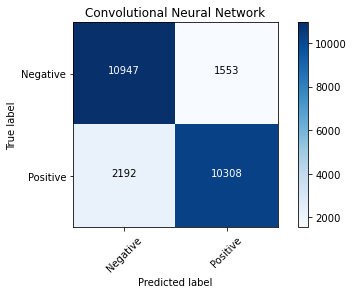

In [62]:
print(classification_report(y_test, sentiment_predict))
cm = confusion_matrix(y_test, sentiment_predict)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Convolutional Neural Network')

In [63]:
print('True Negative  : %d' % cm[0][0])
print('False Positive : %d' % cm[0][1])
print('False Negative : %d' % cm[1][0])
print('True Positive  : %d' % cm[1][1])

True Negative  : 10947
False Positive : 1553
False Negative : 2192
True Positive  : 10308


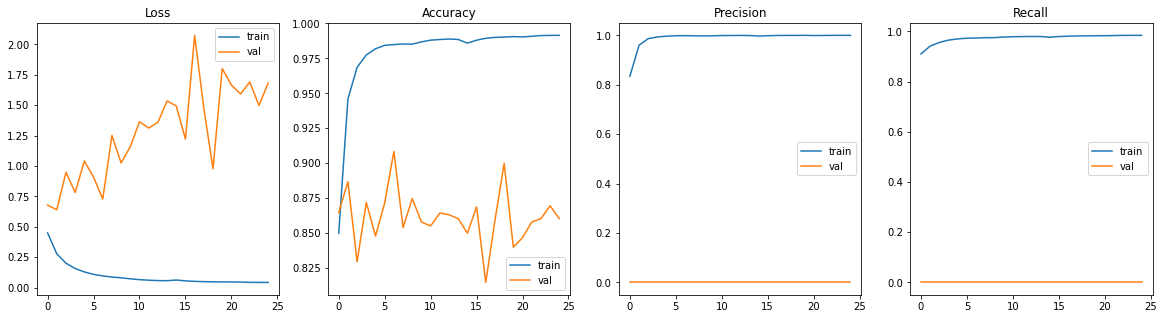

In [64]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].set_title('Loss')
axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='val')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='val')
axs[1].legend()

axs[2].set_title('Precision')
axs[2].plot(history.history['precision'], label='train')
axs[2].plot(history.history['val_precision'], label='val')
axs[2].legend()

axs[3].set_title('Recall')
axs[3].plot(history.history['recall'], label='train')
axs[3].plot(history.history['val_recall'], label='val')
axs[3].legend()

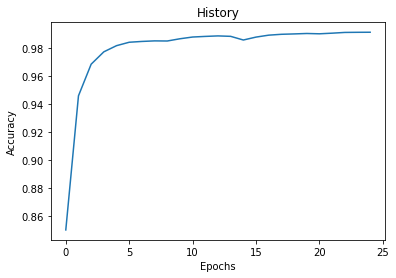

In [65]:
import matplotlib.pyplot as plt
fig = plt.plot(history.history['accuracy'])
title = plt.title("History")
xlabel = plt.xlabel("Epochs")
ylabel = plt.ylabel("Accuracy")

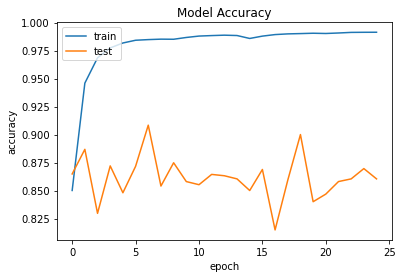

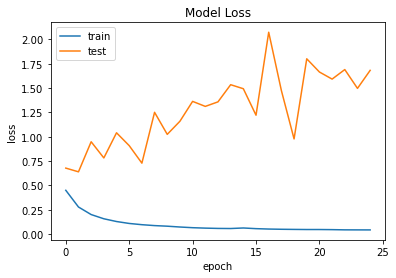

In [66]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [85]:
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

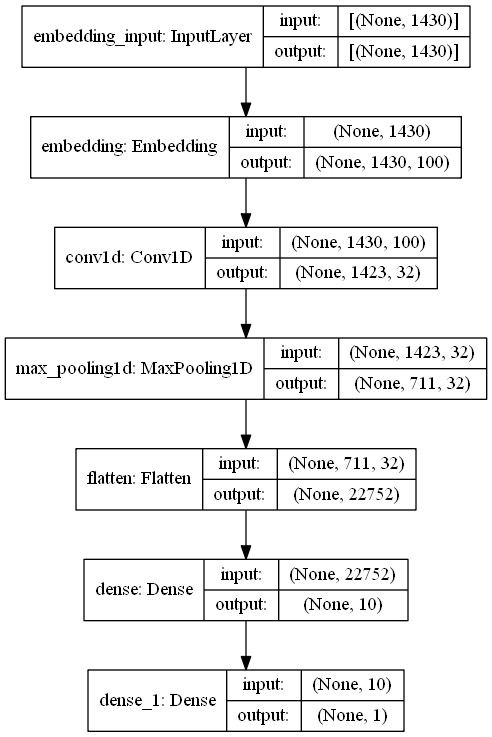

In [86]:
plot_model(model, to_file='C:/Users/Acer/Desktop/model_plot.png', show_shapes=True, show_layer_names=True)

In [103]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
print('Test Accuracy: %f' % (accuracy_score(y_test,sentiment_predict,normalize=True)*100))
print('Test Precision: %f' % (precision_score(y_test,sentiment_predict)*100))
print('Test F1 Score: %f' % (f1_score(y_test,sentiment_predict)*100))
print('Test Recall: %f' % (recall_score(y_test,sentiment_predict)*100))


Test Accuracy: 85.020000
Test Precision: 86.906669
Test F1 Score: 84.627068
Test Recall: 82.464000
